In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [36]:
# Etape 1 - Chargement des données
df = pd.read_csv('./data/employee-earnings-report-2021.csv', encoding='ISO-8859-1')

# Etape 2 - On enlève les lignes vides
df = df.dropna(how='all')

# Etape 3 - Convertir en valeurs numériques Python
numeric_columns = ['REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION_INCENTIVE', 'TOTAL_GROSS']

def clean_numeric_column(column):
    # On supporte le format numérique monétaire bizarre des états-unis
    return column.apply(lambda x: str(x).replace(',', '') if isinstance(x, str) else x).astype(float)

for column in numeric_columns:
    df[column] = clean_numeric_column(df[column])

In [37]:
# Etape 4 - Chercher des données aberrantes

model = IsolationForest(contamination=0.05)
df['outlier'] = model.fit_predict(df[numeric_columns])
outliers = df[df['outlier'] == -1]
outlier_count = len(outliers)

print(f"Number of outliers detected: {outlier_count}")

# S'il y a des outliers, on en enlève au plus 6 comme indiqué dans la donnée
if outlier_count > 0:
    df['anomaly_score'] = model.decision_function(df[numeric_columns])
    top_6_outliers = df.nlargest(6, 'anomaly_score')

    df = df.drop(top_6_outliers.index).drop(['outlier', 'anomaly_score'], axis=1)
else:
    print("No outliers detected.")

Number of outliers detected: 1128


In [38]:
# Etape 5 - Préparation des données pour prédiction

# Ces colonnes ne sont pas pertinentes pour prédire les valeurs
df = df.drop(['NAME', 'TITLE', 'POSTAL'], axis=1)

In [41]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['DEPARTMENT_NAME'] = le.fit_transform(df['DEPARTMENT_NAME'].fillna('Unknown'))

# Séparation des données en attributs et cible
X = df[numeric_columns]
y = df['DEPARTMENT_NAME']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Méthodes d'imputation
imputers = {
    'zero': SimpleImputer(strategy='constant', fill_value=0),
    'median': SimpleImputer(strategy='median'),
    'KNN': KNNImputer(n_neighbors=5),
    'iterative': IterativeImputer(max_iter=10, random_state=42)
}

# Classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Fonction pour évaluer les modèles et calculer les scores F1
def evaluate_models(imputer, classifier):
    # Applique l'imputation sur l'ensemble d'entraînement
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entraînement du classifieur
    classifier.fit(X_train_imputed, y_train)

    # Prédiction
    y_pred = classifier.predict(X_test_imputed)

    # Calcul des scores F1 micro et macro
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    return f1_micro, f1_macro

# Test des combinaisons d'imputation et de classifieurs
results = []
for imputer_name, imputer in imputers.items():
    for clf_name, clf in classifiers.items():
        f1_micro, f1_macro = evaluate_models(imputer, clf)
        results.append((imputer_name, clf_name, f1_micro, f1_macro))

# Conversion des résultats en DataFrame pour affichage
import pandas as pd
results_df = pd.DataFrame(results, columns=['Imputer', 'Classifier', 'F1 Micro', 'F1 Macro'])


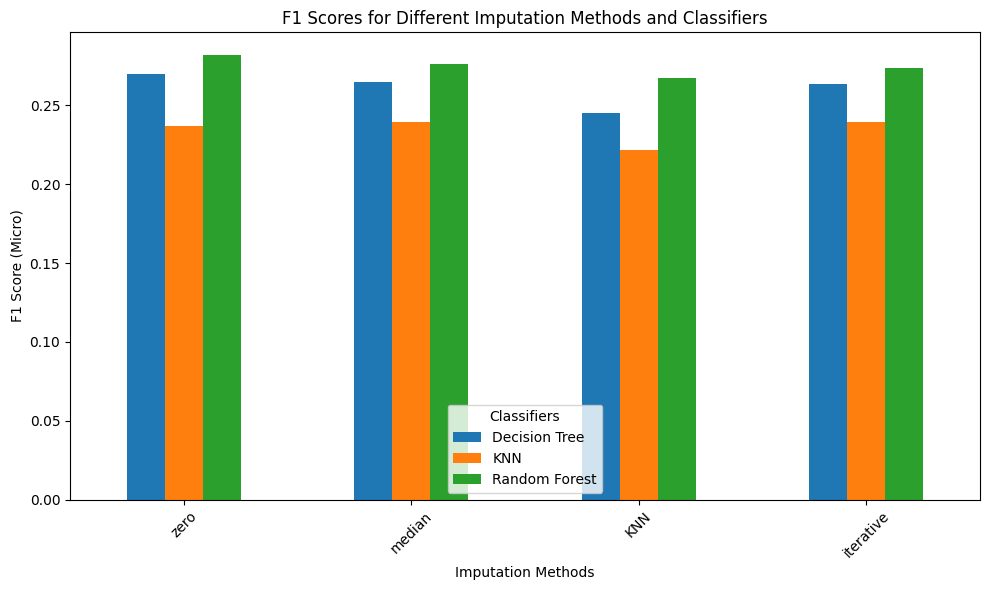

In [49]:
# Step 8: Visualize the results with matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

imputation_order = ['zero', 'median', 'KNN', 'iterative']

pivot_df = results_df.pivot(index='Imputer', columns='Classifier', values='F1 Micro')
pivot_df = pivot_df.loc[imputation_order]

pivot_df.plot(kind='bar', ax=ax)

ax.set_title("F1 Scores for Different Imputation Methods and Classifiers")
ax.set_xlabel("Imputation Methods")
ax.set_ylabel("F1 Score (Micro)")
ax.legend(title="Classifiers")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## Questions & Réponses

### Etape 2

> Combien de lignes et de colonnes a le Data Frame ?

`22552` lignes et `12` colonnes.

> Pour chaque colonne, combien y a-t-il de
données manquantes ?

- **NAME**: 6
- **DEPARTMENT_NAME**: 6
- **TITLE**: 6
- **REGULAR**: 644
- **RETRO**: 22,150
- **OTHER**: 8,423
- **OVERTIME**: 15,706
- **INJURED**: 21,096
- **DETAIL**: 20,493
- **QUINN_EDUCATION_INCENTIVE**: 21,166
- **TOTAL_GROSS**: 6
- **POSTAL**: 6

> Y a-t-il des lignes entièrement vides ?

Oui, il y en a 6.

### Etape 6

> Existe-t-il des classifieurs dans Scikit-learn qui acceptent des données manquantes ?

Oui, nous avons trouvé ce classifieur dans la doc de scikit-learn :

**HistGradientBoostingClassifier** ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html))